<a href="https://colab.research.google.com/github/theneverwhere/eda_itmo_practice/blob/main/transactions_1_eda1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка файлов с гугл диска по ссылке.

In [32]:
!pip install gdown
!pip install fastparquet
import pandas as pd
import numpy as np
import gdown

Файл с транзакциями

In [33]:
file_id = "19q7aXtDZ3_dmWx9Bh_XkaheJCefipo5k"  # Замените на ваш ID
url = f"https://drive.google.com/uc?id={file_id}"
output = "transaction_file.parquet"  # Имя файла после скачивания

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19q7aXtDZ3_dmWx9Bh_XkaheJCefipo5k
From (redirected): https://drive.google.com/uc?id=19q7aXtDZ3_dmWx9Bh_XkaheJCefipo5k&confirm=t&uuid=efbf9509-df3d-4d0f-9b3d-d23bf38c29ce
To: /content/transaction_file.parquet
100%|██████████| 350M/350M [00:06<00:00, 51.5MB/s]


'transaction_file.parquet'

Файл с курсом валют

In [34]:
file_id = "15G689GmHy_qVWsByxe8IONZFCqH903PI"
url = f"https://drive.google.com/uc?id={file_id}"
output = "currency_file.parquet"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=15G689GmHy_qVWsByxe8IONZFCqH903PI
To: /content/currency_file.parquet
100%|██████████| 6.24k/6.24k [00:00<00:00, 10.1MB/s]


'currency_file.parquet'

# Чтение данных

In [35]:
df = pd.read_parquet('transaction_file.parquet', engine='fastparquet')
df_currency = pd.read_parquet('currency_file.parquet', engine='pyarrow')

In [36]:
# Приводим дату транзакции и дату курсов валют к одному формату
df["date"] = df["timestamp"].dt.date
df_currency["date"] = pd.to_datetime(df_currency["date"]).dt.date

In [37]:
transactions_df = df
currency_df = df_currency

In [38]:
# 1. Приводим дату транзакции к дате без времени
transactions_df['date_only'] = transactions_df['timestamp'].dt.floor('D')

# 2. Преобразуем currency_df в словарь {(date, currency): rate}
currency_dict = {
    (row.date, currency): row[currency]
    for _, row in currency_df.iterrows()
    for currency in currency_df.columns if currency != 'date'
}

# 3. Создаём Series с ключами для поиска в словаре
keys = pd.Series(list(zip(transactions_df['date_only'], transactions_df['currency'])))

# 4. Векторизованно применяем словарь с помощью map
rates = keys.map(currency_dict)

# 5. Пересчитываем основные суммы в USD
transactions_df['amount_usd'] = transactions_df['amount'] / rates

# 6. Пересчитываем last_hour_activity.total_amount в USD
transactions_df['last_hour_activity.total_amount_usd'] = \
    transactions_df['last_hour_activity.total_amount'] / rates

# 7. Аналогично для max_single_amount (если нужно)
transactions_df['last_hour_activity.max_single_amount_usd'] = \
    transactions_df['last_hour_activity.max_single_amount'] / rates

# 8. Удаляем временный столбец
transactions_df.drop(columns='date_only', inplace=True)

In [39]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'is_fraud', 'last_hour_activity.num_transactions',
       'last_hour_activity.total_amount',
       'last_hour_activity.unique_merchants',
       'last_hour_activity.unique_countries',
       'last_hour_activity.max_single_amount', 'date', 'amount_usd',
       'last_hour_activity.total_amount_usd',
       'last_hour_activity.max_single_amount_usd'],
      dtype='object')

In [40]:
# Извлечение временных компонентов
transactions_df['hour'] = transactions_df['timestamp'].dt.hour
transactions_df['day_of_week'] = transactions_df['timestamp'].dt.dayofweek
transactions_df['is_night'] = transactions_df['hour'].between(0, 5).astype(int)

# Время с последней транзакции клиента
transactions_df['time_since_last_tx'] = transactions_df.groupby('customer_id')['timestamp'].diff().dt.total_seconds()

# Анализ

In [41]:
!pip install phik
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from phik import resources
from phik.report import plot_correlation_matrix
from phik.report import plot_correlation_matrix
from phik import phik_matrix
sns.set_theme(style="whitegrid", palette="muted")  # стиль + палитра


Гипотеза 1: мошеннические транзацкции преимущественно сконцентрированы в конкретные дни недели и часы (например, ночное время), это может быть общей чертой мошенников.

In [42]:
# Группируем данные по часам и флагу мошенничества
hourly_stats = transactions_df.groupby(['hour', 'is_fraud']).size().unstack().fillna(0)
hourly_stats.columns = ['legit', 'fraud']  # Переименовываем столбцы
hourly_stats['fraud_rate'] = hourly_stats['fraud'] / (hourly_stats['legit'] + hourly_stats['fraud']) * 100

# Создаем график
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Столбцы для легальных и мошеннических транзакций
fig.add_trace(
    go.Bar(
        x=hourly_stats.index,
        y=hourly_stats['legit'],
        name='Легальные транзакции',
        marker_color='#4c72b0',
        opacity=0.7
    ),
    secondary_y=False
)

fig.add_trace(
    go.Bar(
        x=hourly_stats.index,
        y=hourly_stats['fraud'],
        name='Мошеннические транзакции',
        marker_color='#c44e52',
        opacity=0.9
    ),
    secondary_y=False
)

# Линия процента мошенничества
fig.add_trace(
    go.Scatter(
        x=hourly_stats.index,
        y=hourly_stats['fraud_rate'],
        name='Доля мошенничества (%)',
        line=dict(color='#ff7f0e', width=3),
        mode='lines+markers'
    ),
    secondary_y=True
)

# Настройка оформления
fig.update_layout(
    title='Активность мошеннических транзакций по часам суток',
    xaxis_title='Час дня',
    yaxis_title='Количество транзакций',
    hovermode="x unified",
    template='plotly_white',
    barmode='stack',
    height=600
)

# Подписи осей
fig.update_yaxes(title_text="Доля мошенничества (%)", secondary_y=True)
fig.update_yaxes(title_text="Количество транзакций", secondary_y=False)

# Вертикальные линии для ключевых периодов
for hour in [3, 9, 15, 21]:
    fig.add_vline(
        x=hour,
        line_width=1,
        line_dash="dash",
        line_color="gray"
    )

fig.show()

/tmp/ipython-input-3352923557.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




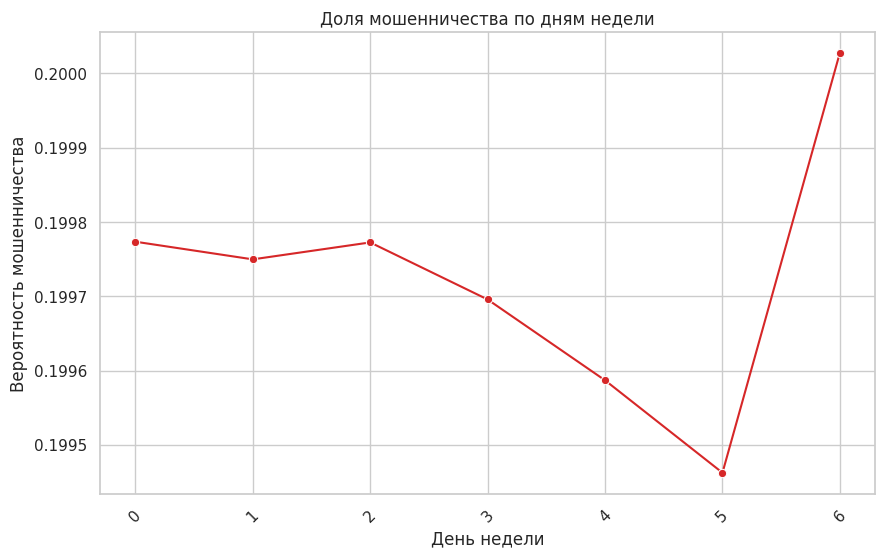

In [43]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=transactions_df,
    x='day_of_week',
    y='is_fraud',
    estimator='mean',
    sort=False,
    marker='o',
    color='#d62728',
    ci=None
)
plt.title('Доля мошенничества по дням недели')
plt.xlabel('День недели')
plt.ylabel('Вероятность мошенничества')
plt.xticks(rotation=45)
plt.show()

Гипотеза подтверждается: с начала рабочей недели и до конца мошенничество сбавляет обороты и снова повышается, приближаясь к новой неделе. Активность мошеннических операций сконцентрировано на ночное время (1.00 - 4.00).

Гипотеза 2. Скорее всего, мошеннические операции содержат суммы, которые отличаются от обычных операций. Как правило, это более предельные суммы, например, слишком маленькие или слишком большие.

/tmp/ipython-input-2363696950.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Сумма (USD)')

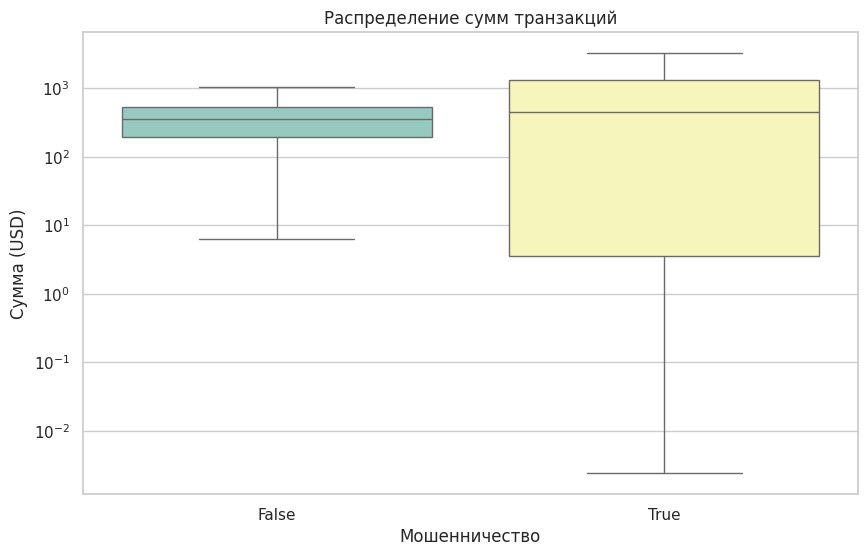

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=transactions_df,
            x='is_fraud',
            y='amount_usd',
            palette="Set3",
            showfliers=False)
plt.yscale('log')
plt.title('Распределение сумм транзакций')
plt.xlabel('Мошенничество')
plt.ylabel('Сумма (USD)')

На ящике с усами видно, что хотя среднее этих групп не сильно отлчиается, но разброс больше у операций, связанных с мошенничеством. Можно убедиться в этом, построив графики распределения.

Text(0.5, 0, 'Сумма (USD, log scale)')

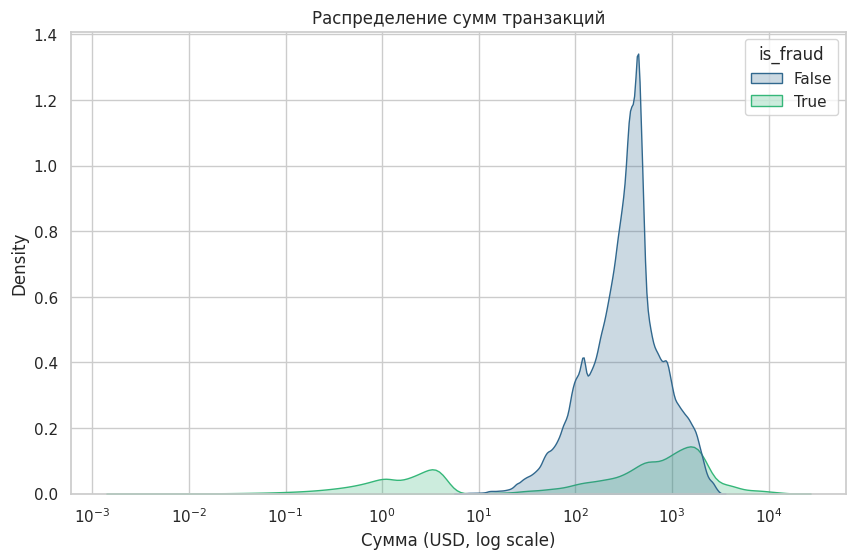

In [45]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=transactions_df, x='amount_usd', hue='is_fraud',
            palette="viridis", log_scale=True, fill=True)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма (USD, log scale)')

Рассмотрим влияние других признаков на уровень мошенничества.

In [46]:
import plotly.express as px

fraud_by_country = transactions_df[transactions_df['is_fraud']==1] \
                   .groupby('country').size().reset_index(name='counts')

fig = px.treemap(fraud_by_country,
                 path=['country'],
                 values='counts',
                 title='Доля мошенничества по странам')
fig.show()

Наиболее подвержены мошенническим схемам транзакции из России, Мексики, Бразилии и Нигерии. Относительно этих стран можно дополнительно проверить, какие именно признаки в группировке по странам влияют на мошеннчиество географически.

Text(0, 0.5, 'Уникальных стран')

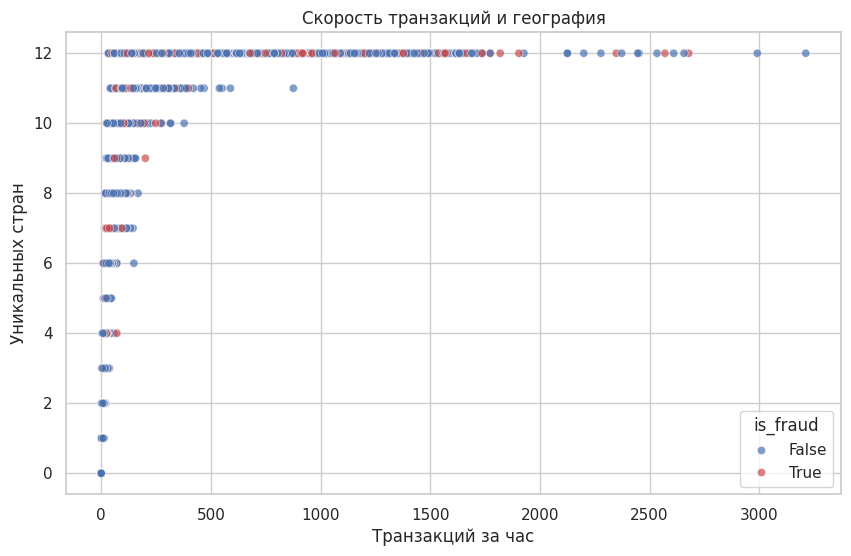

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=transactions_df.sample(4000),
                x='last_hour_activity.num_transactions',
                y='last_hour_activity.unique_countries',
                hue='is_fraud',
                palette=['#4c72b0', '#c44e52'],
                alpha=0.7)
plt.title('Скорость транзакций и география')
plt.xlabel('Транзакций за час')
plt.ylabel('Уникальных стран')

Text(0.5, 0, 'Количество транзакций')

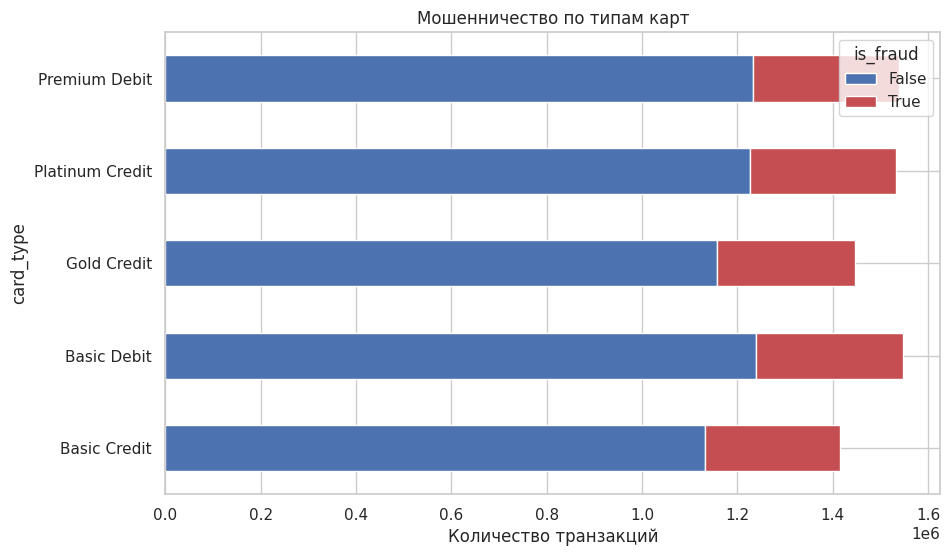

In [48]:
cardtype_fraud = transactions_df.groupby(['card_type', 'is_fraud']).size().unstack()

cardtype_fraud.plot(kind='barh',
                    stacked=True,
                    color=['#4c72b0', '#c44e52'],
                    figsize=(10, 6))
plt.title('Мошенничество по типам карт')
plt.xlabel('Количество транзакций')

In [49]:
fig = px.scatter(transactions_df.sample(100),
                 x='timestamp',
                 y='amount_usd',
                 color='is_fraud',
                 hover_data=['vendor', 'country'],
                 log_y=True)
fig.update_layout(title='Ам ')
fig.show()


Визуально оценим транзакции случайных пользователей.

In [50]:
# Задаём, сколько случайных пользователей хотим
n_users = 1
random_users = transactions_df['customer_id'].dropna().unique()
random_users = pd.Series(random_users).sample(n=n_users, random_state=42)

# Фильтруем по этим пользователям
filtered_df = transactions_df[transactions_df['customer_id'].isin(random_users)]

# Строим график
fig = px.scatter(
    filtered_df,
    x='timestamp',
    y='amount_usd',
    color='is_fraud',
    hover_data=['vendor', 'country', 'customer_id'],
    log_y=True,
    title=f"Аномальные суммы транзакций для {n_users} случайных пользователей"
)

fig.update_layout(template='plotly_dark')  # Тема графика
fig.show()

Гипотеза 3. Возможно, что мошеннические транзакции могут проводиться на конкретных платформах или устройствах, это может быть актуально для проверенных схем. Это можно проверить.

Text(0.5, 0, 'Доля мошенничества')

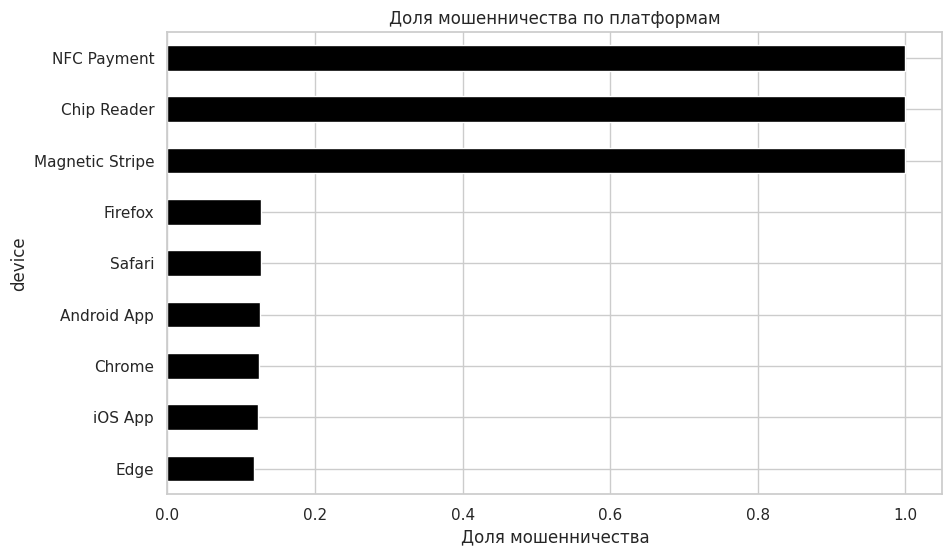

In [51]:
device_risk = transactions_df.groupby('device')['is_fraud'].mean().sort_values()
plt.figure(figsize=(10, 6))
device_risk.plot(kind='barh', color='black')
plt.title('Доля мошенничества по платформам')
plt.xlabel('Доля мошенничества')

Есть явный топ 3 избранных платформ для мошеннических транзакций. Эти условия можно сгруппировать и выдвинуть гипотезу о связи устройст, например, с географией транзакции.

In [52]:
# Группируем по клиенту, считаем общее число и число мошеннических транзакций
client_fraud_stats = df.groupby('customer_id').agg(
    total_transactions=('transaction_id', 'count'),
    fraud_transactions=('is_fraud', 'sum')
).reset_index()

# Доля мошеннических транзакций
client_fraud_stats['fraud_ratio'] = client_fraud_stats['fraud_transactions'] / client_fraud_stats['total_transactions']

# Посмотрим топ клиентов с самой высокой долей мошенничества (с минимум 5 транзакций)
top_fraud_clients = client_fraud_stats[client_fraud_stats['total_transactions'] >= 5] \
    .sort_values('fraud_ratio', ascending=False).head(10)

print(top_fraud_clients)

     customer_id  total_transactions  fraud_transactions  fraud_ratio
1323  CUST_34756                1335                 267          0.2
1320  CUST_34728                1325                 265          0.2
1315  CUST_34631                1560                 312          0.2
3601  CUST_77813                1820                 364          0.2
3591  CUST_77476                1250                 250          0.2
3590  CUST_77465                1370                 274          0.2
3581  CUST_77286                1335                 267          0.2
3579  CUST_77230                1425                 285          0.2
3572  CUST_77172                1795                 359          0.2
1344  CUST_35161                1955                 391          0.2


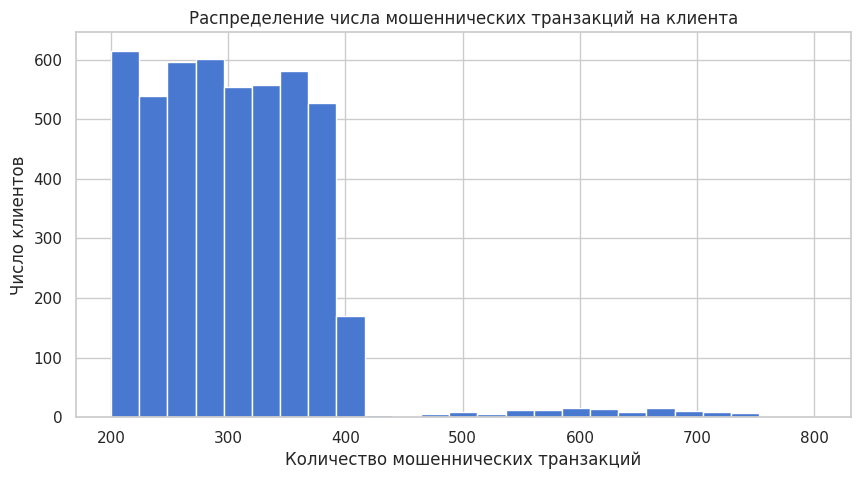

In [53]:
plt.figure(figsize=(10,5))
client_fraud_stats['fraud_transactions'].hist(bins=25)
plt.title('Распределение числа мошеннических транзакций на клиента')
plt.xlabel('Количество мошеннических транзакций')
plt.ylabel('Число клиентов')
plt.show()

Гипотеза 4. Возможно, транзакции с разными курсами валют отлчиаются по мошенничеству, потому что курсы валют могут использовать разные слабости в финансовых системах.

In [54]:
# Фильтруем только мошеннические транзакции
fraud_df = transactions_df[transactions_df['is_fraud'] == 1]

# Группируем по валюте
fraud_by_currency = fraud_df.groupby('currency').size().reset_index(name='fraud_count')
fraud_by_currency = fraud_by_currency.sort_values('fraud_count', ascending=False)

# Pie chart
fig_pie = px.pie(
    fraud_by_currency,
    names='currency',
    values='fraud_count',
    title='Доля валют в мошеннических транзакциях',
    color_discrete_sequence=px.colors.sequential.Reds
)
fig_pie.update_layout(template='plotly_white')
fig_pie.show()

Не дает сильной информации, так как есть зависимость от самой страны. Возможно, нужно убрать домашние транзакции, чтобы увидеть более релеватные результаты.

In [55]:
# Словарь: валюта → родная страна
currency_country_map = {
    'GBP': 'UK',
    'BRL': 'Brazil',
    'JPY': 'Japan',
    'AUD': 'Australia',
    'NGN': 'Nigeria',
    'EUR': 'Germany',   # можно выбрать любую страну-носителя евро
    'MXN': 'Mexico',
    'RUB': 'Russia',
    'CAD': 'Canada',
    'SGD': 'Singapore',
    'USD': 'USA'
}

# Берём только нужные колонки
df_small = df[['currency', 'country', 'is_fraud']].copy()

# Добавляем колонку с "родной страной" для валюты
df_small['native_country'] = df_small['currency'].map(currency_country_map)

# Фильтруем: страна транзакции не равна родной стране валюты
mask = df_small['country'] != df_small['native_country']

# Оставляем только мошеннические транзакции
df_filtered = df_small[mask & (df_small['is_fraud'] == 1)]

# Группируем по валюте
fraud_by_currency = df_filtered.groupby('currency').size().reset_index(name='fraud_count')

# Строим график
fig = px.bar(fraud_by_currency,
             x='currency',
             y='fraud_count',
             title='Частота мошенничества по валютам (за границей)',
             text='fraud_count')
fig.update_traces(textposition='outside')
fig.show()


In [56]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'is_fraud', 'last_hour_activity.num_transactions',
       'last_hour_activity.total_amount',
       'last_hour_activity.unique_merchants',
       'last_hour_activity.unique_countries',
       'last_hour_activity.max_single_amount', 'date', 'amount_usd',
       'last_hour_activity.total_amount_usd',
       'last_hour_activity.max_single_amount_usd', 'hour', 'day_of_week',
       'is_night', 'time_since_last_tx'],
      dtype='object')

Text(0.5, 1.0, 'Время между транзакциями')

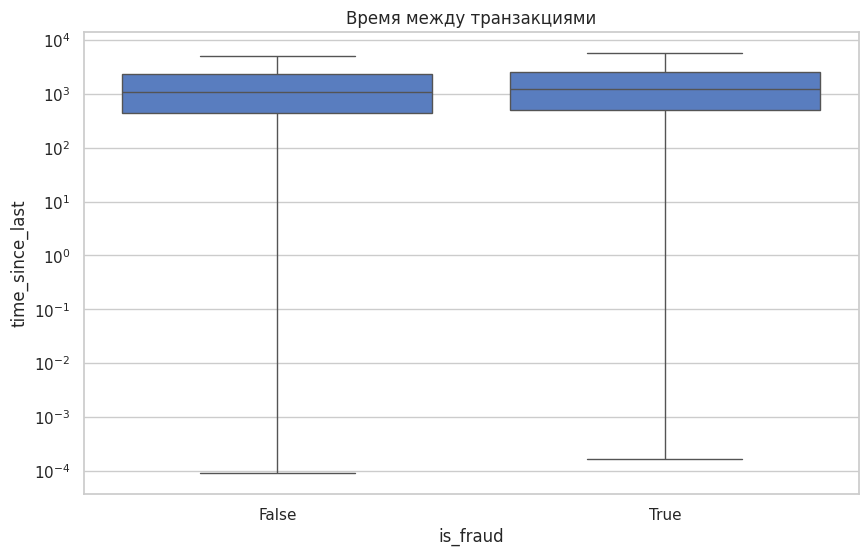

In [57]:
transactions_df['time_since_last'] = transactions_df.groupby('customer_id')['timestamp'].diff().dt.total_seconds()
plt.figure(figsize=(10, 6))
sns.boxplot(data=transactions_df, x='is_fraud', y='time_since_last', showfliers=False)
plt.yscale('log')
plt.title('Время между транзакциями')

# трудно что-то сказать, но надеялся увидеть отличия

Проведём анализ корреляций, чтобы узнать, какую связь переменные имеют с меткой мошенничества.

Text(0.5, 1.0, 'Корреляция факторов риска')

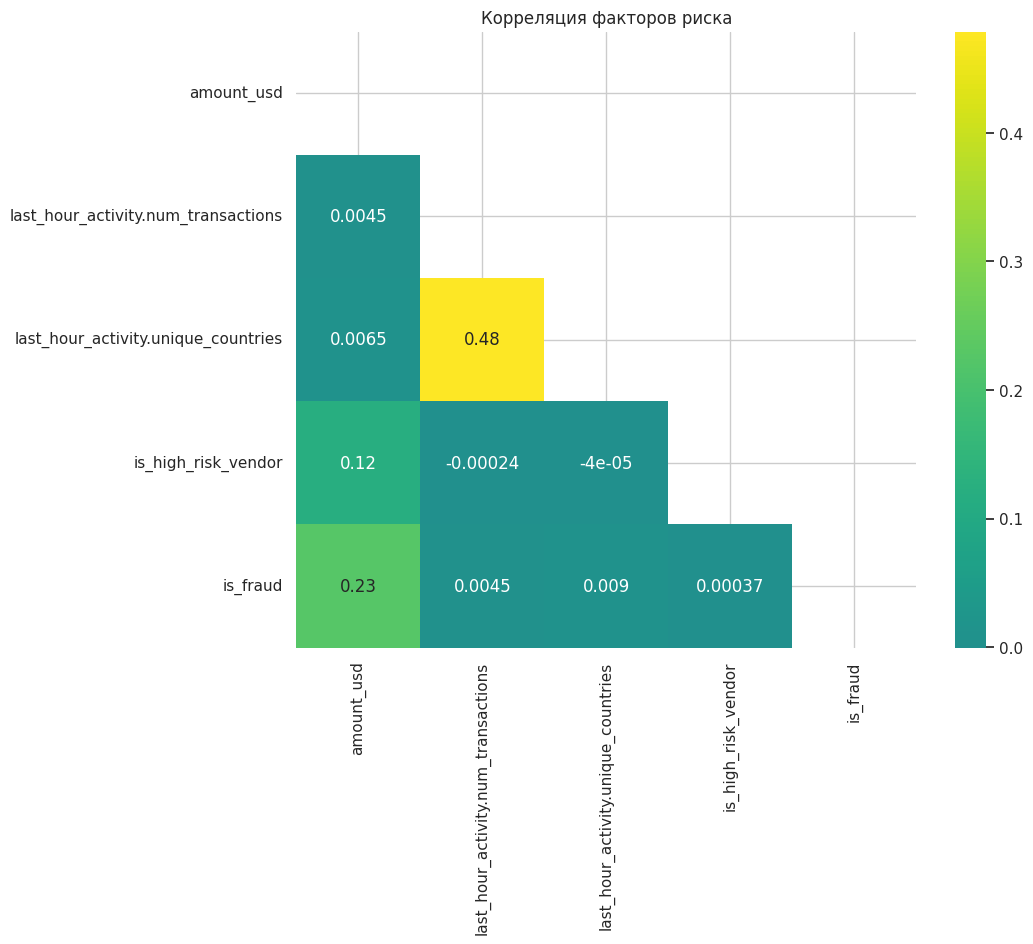

In [58]:
fraud_corr = transactions_df[['amount_usd', 'last_hour_activity.num_transactions',
                            'last_hour_activity.unique_countries',
                            'is_high_risk_vendor', 'is_fraud']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(fraud_corr,
            annot=True,
            cmap='viridis',
            center=0,
            mask=np.triu(np.ones_like(fraud_corr, dtype=bool)))
plt.title('Корреляция факторов риска')

Применим phik-корреляцию для обзора связей с категориальными переменными, а также для поиска нелинейных закономерностей.

In [59]:
SAMPLE_SIZE = 1_000_000  # можно ещё меньше, если нужно
TARGET = 'is_fraud'
# Список столбцов, которые исключаем из анализа
exclude_cols = [
    'transaction_id', 'customer_id', 'card_number',
    'device_fingerprint', 'ip_address',
    'timestamp', 'date']

df_sample = df.sample(SAMPLE_SIZE, random_state=42) if len(df) > SAMPLE_SIZE else df.copy()

cols_to_use = [col for col in df_sample.columns if col not in exclude_cols + [TARGET]]

results = []
for col in cols_to_use:
    try:
        phik_val = df_sample[[col, TARGET]].phik_matrix(
            interval_cols=[col] if pd.api.types.is_numeric_dtype(df_sample[col]) else None
        ).iloc[0, 1]
        results.append((col, phik_val))
    except Exception:
        pass  # пропускаем проблемные столбцы

corr_df = pd.DataFrame(results, columns=['feature', 'phik_correlation'])
corr_df = corr_df.sort_values(by='phik_correlation', ascending=False)

# График
fig = px.bar(corr_df,
             x='feature',
             y='phik_correlation',
             title='PHIK корреляция с is_fraud',
             text='phik_correlation')

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_title='Признак',
                  yaxis_title='PHIK корреляция',
                  xaxis_tickangle=-45,
                  height=550)

fig.show()

Самая сильная корреляция с фактом мошенничества у наличия/отсуствия домашнего региона, а также у факта присуствия физической карты при оплате.
Так же важе выбор устройства для совершения транзакции и время транзакции (ночные часы).
